Number of FLIR RGB images:  10319
Number of FLIR Thermal images:  10742
Number of LLVIP RGB images:  12025
Number of LLVIP Thermal images:  12025
Loading annotations into memory...
Done (t=0.13s)
Creating index...
index created!


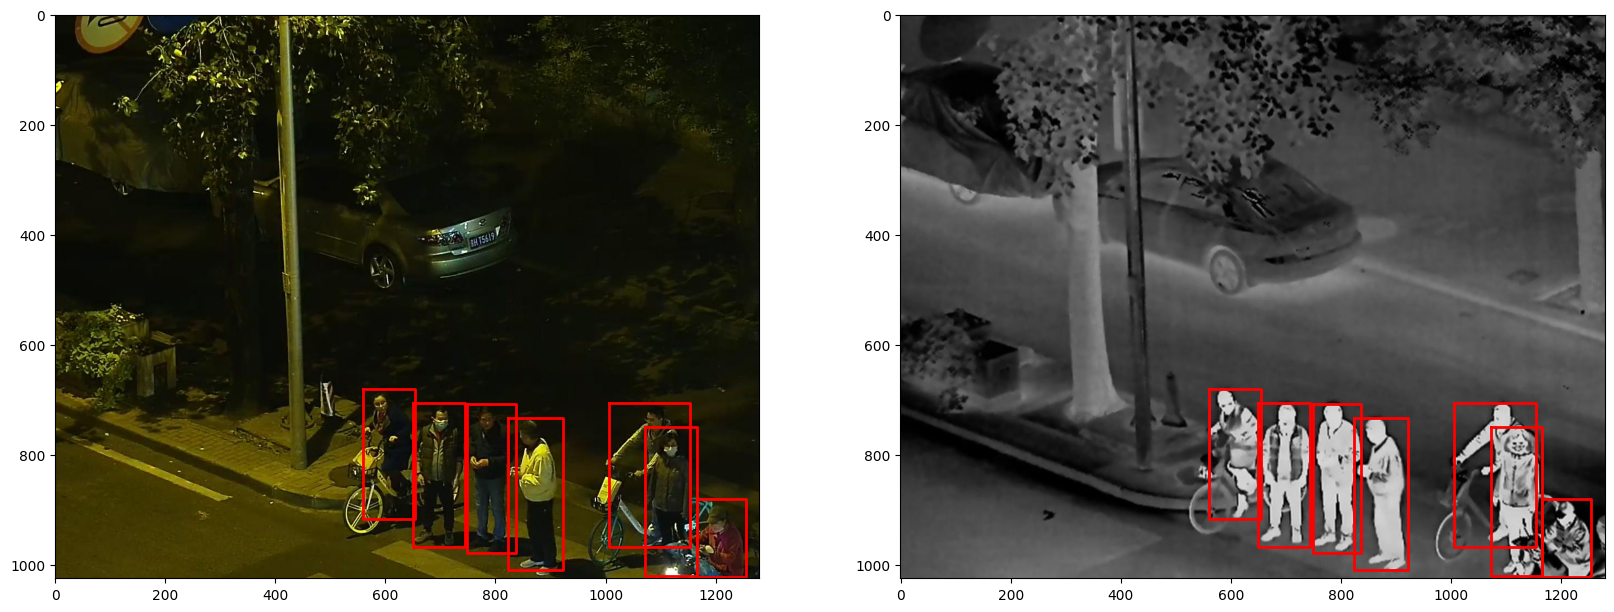

In [1]:
# Base imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pycocotools.coco import COCO
from PIL import Image
from torchvision import transforms
# Custom imports
from model import InfusionNet
import tools.dct as dct_tools

flir_path = '../data/FLIR/'
llvip_path = '../data/LLVIP/'

flir_rgbimages = os.listdir(flir_path + 'images_rgb_train/data')
flir_thermalimages = os.listdir(flir_path + 'images_thermal_train/data')
llvip_rgbimages = os.listdir(llvip_path + 'visible/train')

llvip_thermalimages = os.listdir(llvip_path + 'infrared/train')

print('Number of FLIR RGB images: ', len(flir_rgbimages))
print('Number of FLIR Thermal images: ', len(flir_thermalimages))

print('Number of LLVIP RGB images: ', len(llvip_rgbimages))
print('Number of LLVIP Thermal images: ', len(llvip_thermalimages))

llvip = COCO(llvip_path + 'LLVIP.json') # load the dataset
llvip_ids = llvip.getImgIds()
img_obj = llvip.loadImgs([llvip_ids[1]])
anns_obj = llvip.loadAnns(llvip.getAnnIds(imgIds=[llvip_ids[1]]))


rgb_img = Image.open(llvip_path + 'visible/train/' + img_obj[0]['file_name'])
ir_img = Image.open(llvip_path + 'infrared/train/' + img_obj[0]['file_name'])

def plot_bbox(img, anns):
    # draw bounding boxes
    for ann in anns:
        x, y, w, h = ann['bbox']
        plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], linewidth=2, color='r')

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
# draw bounding boxes
plot_bbox(rgb_img, anns_obj)
plt.subplot(1,2,2)
plt.imshow(ir_img)
# draw bounding boxes
plot_bbox(ir_img, anns_obj)
plt.show()

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


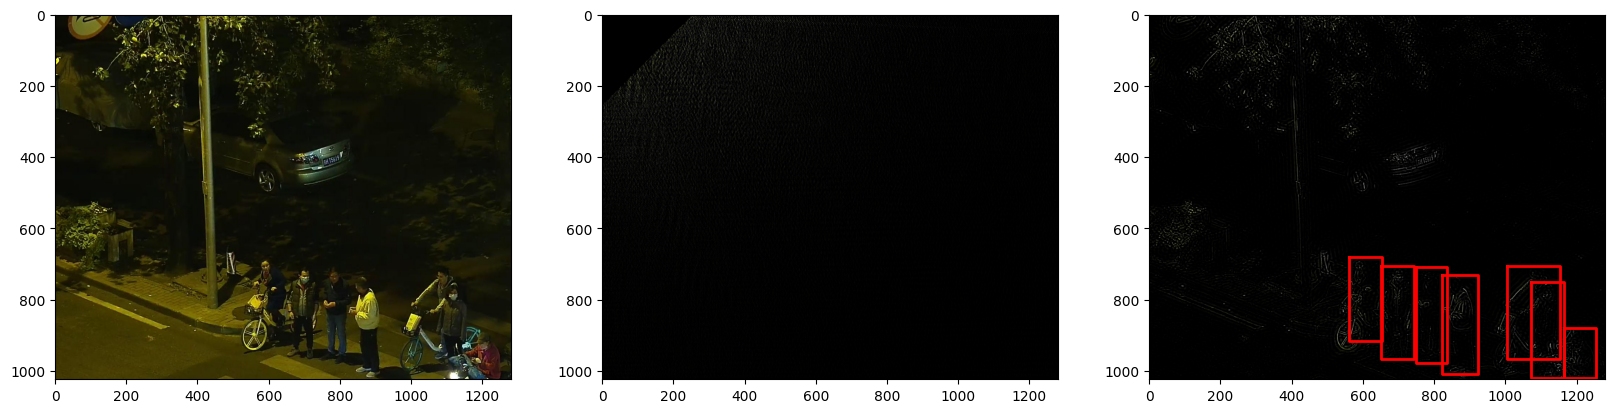

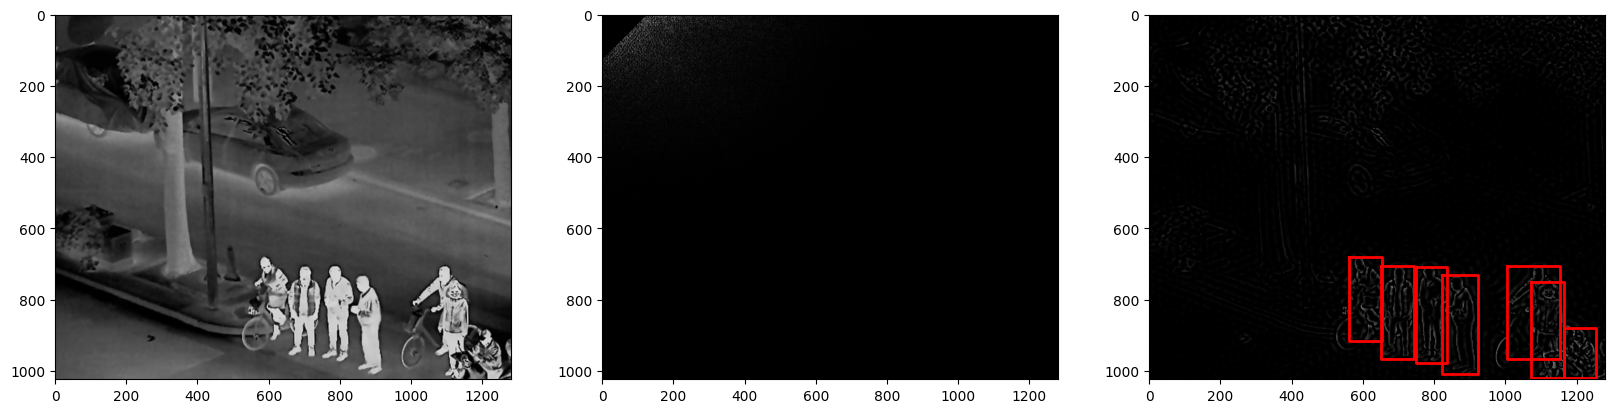

In [2]:
transforms = transforms.Compose([transforms.ToTensor()])

def plot_dct(input, masked_freq, output):
    gs = gridspec.GridSpec(1, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(gs[0,0])
    input = input.squeeze(0).permute(1,2,0)
    plt.imshow(input)
    plt.subplot(gs[0,1])
    masked_freq = masked_freq.squeeze(0).permute(1,2,0)
    plt.imshow(masked_freq)
    plt.subplot(gs[0,2])
    output = output.squeeze(0).permute(1,2,0)
    plt.imshow(output)

rgb_tensor = transforms(rgb_img).unsqueeze(0)
dct_tensor = dct_tools.dct_2d(rgb_tensor, norm='ortho')
masked_tensor = dct_tools.mask_image(dct_tensor, 0.1)
masked_rgb = dct_tools.idct_2d(masked_tensor, norm='ortho')

plot_dct(rgb_tensor, masked_tensor, masked_rgb)
plot_bbox(rgb_tensor, anns_obj)

ir_tensor = transforms(ir_img).unsqueeze(0)

dct_tensor = dct_tools.dct_2d(ir_tensor, norm='ortho')

masked_tensor = dct_tools.mask_image(dct_tensor, 0.05)

masked_ir = dct_tools.idct_2d(masked_tensor, norm='ortho')

plot_dct(ir_tensor, masked_tensor, masked_ir)
plot_bbox(ir_tensor, anns_obj)

In [4]:
from model import InfusionNet

infusion_model = InfusionNet(num_features=16, reduction=8, tau = 0.2)

input_tensors = torch.cat((torch.cat((rgb_tensor, ir_tensor), dim=1),torch.cat((rgb_tensor, ir_tensor), dim=1)), dim=0)

output_tensor = infusion_model(input_tensors)

print(output_tensor.shape)

torch.Size([2, 48, 256, 320])


In [5]:
from yolov7 import YOLOv7

yolo = YOLOv7(cfg_path='yolov7_LLVIP.yaml', num_classes=1, num_features=64)

Initializing EELAN backbone...
Initializing stem...
Initializing stage1...
Initializing stage2...
Initializing stage3...
Initializing stage4...


In [6]:
import torch.nn as nn
from yolov7 import YOLOv7
from model import InfusionNet
class InfusionDetector(nn.Module):
    def __init__(self, num_features, reduction, tau):
        super(InfusionDetector, self).__init__()
        self.infusionnet = InfusionNet(num_features, reduction, tau)
        self.yolo = YOLOv7(cfg_path='yolov7_LLVIP.yaml', num_classes=1, num_features=num_features)
        
    def forward(self, x):
        x = self.infusionnet(x)
        x = self.yolo(x)
        return output_tensor

model = InfusionDetector(num_features=16, reduction=8, tau = 0.2)

Initializing EELAN backbone...
Initializing stem...
Initializing stage1...
Initializing stage2...
Initializing stage3...
Initializing stage4...


In [8]:
yolo(output_tensor)

TypeError: 'NoneType' object is not callable